In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import numpy as np

In [3]:
simulator = AerSimulator()
simulator.available_devices()

('CPU',)

In [4]:
simulator.available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

In [79]:
def BitReversalPermutationMatrix(qc: QuantumCircuit, register: QuantumRegister):
    # Applies bit-reversal permutation matrix to the given register
    
    n = register.size # number of qubits in register
    
    for i in range(n//2):
        qc.swap(register[i], register[n-1-i])

def QFT(qc: QuantumCircuit, register: QuantumRegister, add_barriers: bool = False):
    # Quantum Fourier Transform applied to the given register
    
    n = register.size # number of qubits in register
    phases = -2*np.pi/np.array([2**j for j in range(1, n+1)])
    
    for i in reversed(range(n)):
        qc.h(register[i])
        
        k = i
        for j in range(i):
            qc.cp(phases[k], register[j], register[i])
            k -= 1
            
        if add_barriers:
            qc.barrier(register)
        
    BitReversalPermutationMatrix(qc, register)

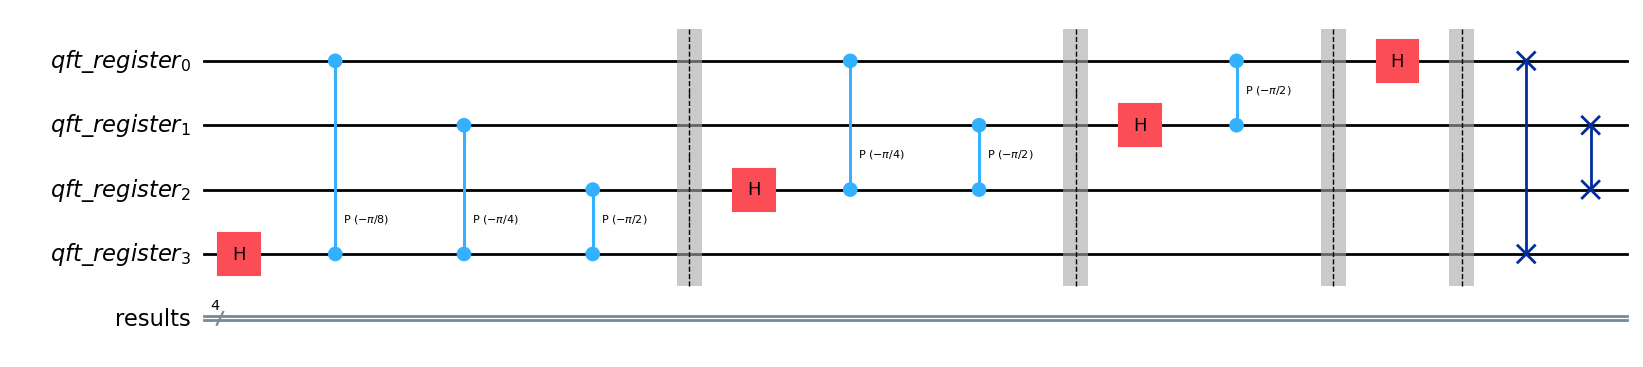

In [108]:
n_qubits = 4

qft_register = QuantumRegister(n_qubits, 'qft_register')
classic_register = ClassicalRegister(n_qubits, 'results')

qc = QuantumCircuit(qft_register, classic_register)

QFT(qc, qft_register, add_barriers=True)

qc.draw('mpl', style="iqp")

In [109]:
Statevector(qc)

Statevector([0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j,
             0.25+0.j, 0.25+0.j, 0.25+0.j, 0.25+0.j],
            dims=(2, 2, 2, 2))


In [86]:
np.random.seed(0)
data = np.random.rand(2**n_qubits)
data = data/np.linalg.norm(data) # normalize vector

In [87]:
data

array([0.21986706, 0.28652098, 0.2414806 , 0.21829249, 0.16972566,
       0.25875974, 0.1753073 , 0.35726437, 0.38606503, 0.15361532,
       0.3171829 , 0.21188723, 0.22757146, 0.37081488, 0.02845865,
       0.03490596])

In [88]:
Statevector(StatePreparation(data))

Statevector([0.21986706+1.18943252e-16j, 0.28652098+9.19997914e-17j,
             0.2414806 +3.67829375e-17j, 0.21829249+4.56101322e-17j,
             0.16972566+3.75837593e-17j, 0.25875974+2.26493206e-18j,
             0.1753073 +6.31385926e-17j, 0.35726437+1.03751811e-16j,
             0.38606503+5.05939298e-17j, 0.15361532+1.05713411e-16j,
             0.3171829 +2.26624079e-16j, 0.21188723+1.95651744e-16j,
             0.22757146+1.68386506e-16j, 0.37081488+2.77536971e-16j,
             0.02845865+3.68761452e-17j, 0.03490596+6.45608452e-17j],
            dims=(2, 2, 2, 2))


In [89]:
qft_register = QuantumRegister(n_qubits, 'qft_register')
classic_register = ClassicalRegister(n_qubits, 'results')

qc = QuantumCircuit(qft_register, classic_register)

init_state_prep = StatePreparation(data)
qc.append(init_state_prep, qft_register)
QFT(qc, qft_register)

In [90]:
data_dft = np.fft.fft(data)/(2**(n_qubits/2))
data_dft

array([ 0.91442991+0.j        , -0.11331598-0.01726913j,
        0.01195129-0.06195528j, -0.04769356-0.14229837j,
        0.06019994-0.06184022j,  0.04327822-0.08822144j,
        0.0923662 +0.11549349j, -0.04846664-0.021038j  ,
       -0.03160058+0.j        , -0.04846664+0.021038j  ,
        0.0923662 -0.11549349j,  0.04327822+0.08822144j,
        0.06019994+0.06184022j, -0.04769356+0.14229837j,
        0.01195129+0.06195528j, -0.11331598+0.01726913j])

In [91]:
Statevector(qc)

Statevector([ 0.91442991+4.06504710e-16j, -0.11331598-1.72691334e-02j,
              0.01195129-6.19552800e-02j, -0.04769356-1.42298370e-01j,
              0.06019994-6.18402196e-02j,  0.04327822-8.82214388e-02j,
              0.0923662 +1.15493494e-01j, -0.04846664-2.10379956e-02j,
             -0.03160058-3.70401090e-17j, -0.04846664+2.10379956e-02j,
              0.0923662 -1.15493494e-01j,  0.04327822+8.82214388e-02j,
              0.06019994+6.18402196e-02j, -0.04769356+1.42298370e-01j,
              0.01195129+6.19552800e-02j, -0.11331598+1.72691334e-02j],
            dims=(2, 2, 2, 2))


In [92]:
np.linalg.norm(data_dft-Statevector(qc).data,ord=1)

np.float64(2.3394321579062194e-15)

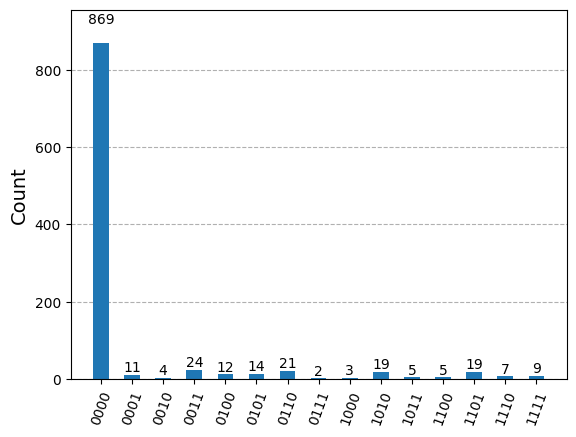

In [99]:
transpiled_qc = transpile(qc, simulator)

N = 1024

transpiled_qc.measure(qft_register, classic_register)
job = simulator.run(transpiled_qc, shots=N)
# Get the result
result = job.result()
# Get the counts of the results
counts = result.get_counts()

plot_histogram(counts)

In [100]:
def bin_2_int(bin_repr: str) -> int:
    # given a binary string, returns the integer that it represents
    num_bits = len(bin_repr)
    n = 0
    for i in range(num_bits):
        if bin_repr[-1 - i] == "1":
            n += 2**i

    return n

In [101]:
vec_hat = np.zeros(2**n_qubits)
for key in counts:
    i = bin_2_int(key)
    vec_hat[i] = counts[key]/N
    
vec_hat

array([0.84863281, 0.01074219, 0.00390625, 0.0234375 , 0.01171875,
       0.01367188, 0.02050781, 0.00195312, 0.00292969, 0.        ,
       0.01855469, 0.00488281, 0.00488281, 0.01855469, 0.00683594,
       0.00878906])

In [102]:
abs(data_dft)**2

array([0.83618206, 0.01313874, 0.00398129, 0.0225235 , 0.00744825,
       0.00965603, 0.02187026, 0.00279161, 0.0009986 , 0.00279161,
       0.02187026, 0.00965603, 0.00744825, 0.0225235 , 0.00398129,
       0.01313874])

In [103]:
np.linalg.norm(vec_hat-abs(data_dft)**2, ord=1)

np.float64(0.052873691324519745)